In [18]:
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision import utils as T_utils

from datasets import load_dataset
from vae_network import VAE  

from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import Image

In [19]:
gpu_index = 0
device = T.device(f'cuda:{gpu_index}' if T.cuda.is_available() else 'cpu')
print(f'Device: {device}')
if T.cuda.is_available():
        print(T.cuda.mem_get_info(gpu_index))
        print('( global free memory , total GPU memory )')

Device: cuda:0
(78196703232, 85198045184)
( global free memory , total GPU memory )


In [20]:
# Load dataset
full_dataset = load_dataset('thorirhrafn/minigrid_obs_data', split='train')

split_dataset = full_dataset.train_test_split(test_size=0.05, seed=42)
train_dataset = split_dataset['train']
test_dataset = split_dataset['test']

# Convert to torch.Tensor during batch loading
train_dataset = train_dataset.with_transform(
    lambda example: {
        "image_tensor": T.tensor(example["image_tensor"], dtype=T.float32)
    }
)
test_dataset = test_dataset.with_transform(
    lambda example: {
        "image_tensor": T.tensor(example["image_tensor"], dtype=T.float32)
    }
)

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

torch.Size([3, 56, 56])


/tmp/ipykernel_743555/4196629761.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor = T.tensor(img_tensor)


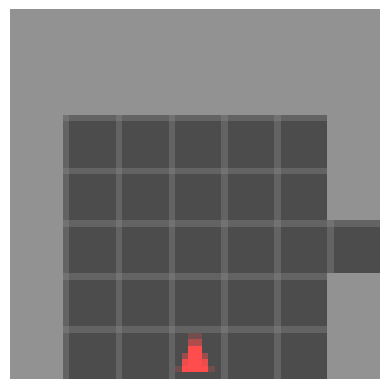

In [21]:
sample = test_dataset[0]
img_tensor = sample['image_tensor']
tensor = T.tensor(img_tensor)
print(tensor.shape)

#Check an image
to_pil = transforms.ToPILImage()
image = to_pil(tensor)

plt.imshow(image)
plt.axis("off")
plt.show()

In [22]:
model = VAE(latent_dim=8)
model.load_state_dict(T.load("./model_folder/vae_model.pt", weights_only=True))
model.to(device)
model.eval()

VAE(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc_mu): Linear(in_features=6272, out_features=8, bias=True)
  (fc_logvar): Linear(in_features=6272, out_features=8, bias=True)
  (decoder_input): Linear(in_features=8, out_features=6272, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): Sigmoid()
  )
)

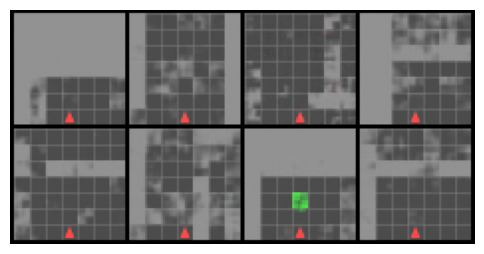

In [23]:
# Generate samples from the learned latent space
model.eval()
with T.no_grad():
    z = T.randn(8, model.latent_dim).to(device)
    samples = model.decoder(model.decoder_input(z).view(-1, 128, 7, 7)).cpu()

def show_images(imgs):
    imgs = imgs[:16]  # Show 16 images
    grid = T_utils.make_grid(imgs, nrow=4, padding=2)
    plt.figure(figsize=(6, 6))
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis('off')
    plt.show()

show_images(samples)

In [24]:
print(z)

tensor([[-0.1450,  0.6725, -0.5463, -0.3025,  0.5224,  0.8932,  0.0523,  2.8406],
        [ 0.1255, -0.4093, -0.1948, -0.1747, -1.3551,  0.3571,  2.0381,  0.1829],
        [ 0.0395, -2.8902,  0.0943,  0.5124, -1.0377,  0.9240,  0.4322, -4.2658],
        [ 0.8378, -0.3466, -0.4312, -0.9285,  1.1617, -0.4972, -0.5485,  1.3426],
        [-1.7424, -0.3576,  0.5258,  0.3746,  0.7444, -1.6953,  1.7982,  0.0230],
        [ 1.4258, -0.5379, -1.0388,  0.1433,  0.0635, -1.3705,  0.0288,  0.2455],
        [ 0.7865,  1.1575, -0.8909, -0.8265,  0.0486, -0.8729,  0.8519,  0.6508],
        [-0.7891,  0.1916, -1.9098, -0.0142,  0.4542, -1.1181, -0.5544,  0.3754]],
       device='cuda:0')


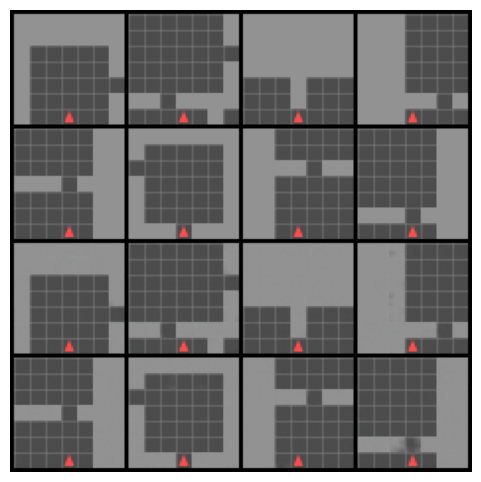

In [25]:
model.eval()
with T.no_grad():
    batch = next(iter(test_loader))
    x = batch["image_tensor"].to(device)
    x_hat, _, _ = model(x)
    show_images(T.cat([x[:8].cpu(), x_hat[:8].cpu()], dim=0))